In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

In [2]:
def calculate_cagr(return_df):
    '''rtn을 받았을 때, CAGR을 계산합니다'''
    holding_year = (len(return_df) / 365)
    cum = (return_df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    return cagr

def run_alpha_regression(return_dict:dict, 
                         mkt_rtn:pd.DataFrame,
                         constant=True):
    
    '''return_dict : 포트폴리오 리턴(dict)
       mkt_rtn : 마켓 인덱스의 리턴이 들어감
       constant : True(Default)/ False
       '''
    
    for key, strategy_df in return_dict.items():  
        if str(key) =="count":
            continue
        
        if constant:
            model = OLS(strategy_df, add_constant(mkt_rtn))
        else:
            model = OLS(strategy_df, mkt_rtn)
        result = model.fit()
        
        print(f"{key} Regression Result")
        print(result.summary2())
        
def print_statistics(return_dict:dict,
                     mkt_rtn:pd.DataFrame):
        
    mean = [df.mean().round(6) for key, df in return_dict.items()]          
    std = [df.std() for key, df in return_dict.items()]
    cagr =[calculate_cagr(df) * 100 for key, df in return_dict.items()]          
    return_df = pd.DataFrame([cagr,mean,std], 
                             index=["CAGR", "Mean","STD"])
    
    
    mkt = pd.DataFrame([calculate_cagr(mkt_rtn) * 100, mkt_rtn.mean(), mkt_rtn.std()],
                           index=["CAGR", "Mean","STD"], 
                           columns=["MKT"])
    
    return_df = pd.concat([return_df, mkt], axis=1)
    return_df.loc["Shape",:] = (return_df.loc["Mean",:]*365)/ (return_df.loc["STD",:]*np.sqrt(365))
    return return_df
        
def draw_return_result(return_dict:dict, 
                       with_mkt=False,
                       mkt_rtn=None):
    
    '''rtn_result : dict(리턴이 담긴 딕셔러니)
       with_mkt   : bool -> 마켓인덱스를 함께 그릴지 표시
       with_mkt가 True일 경우 mkt_rtn을 줘야한다'''
        
    for key, df in return_dict.items():
        fig, axes = plt.subplots(3,1, sharex=True, figsize=(24,24), 
                                 gridspec_kw={'height_ratios': [4, 1, 1]})
        cum_df = (df+1).cumprod()
        cum_df.plot(ax=axes[0])
            
        axes[0].set_title("Cross-Sectional Momentum Cummulative returns weighted by marketcap")
        axes[0].grid()
        axes[0].legend(["Startegy","MKT"])
        
        peak = cum_df.cummax()
        drawdown = (cum_df-peak)/peak
        drawdown.plot(ax=axes[1])
        axes[1].set_title("Draw Down")
        axes[1].grid()
        
        df.plot(ax=axes[2])
        axes[2].grid()
        
        if with_mkt:
            mktcum = (mkt_rtn+1).cumprod()
            mktcum.plot(ax=axes[0])
            axes[0].grid()
            axes[0].legend(["Startegy","MKT"])
            
            peak = mktcum.cummax()
            drawdown = (mktcum-peak) / peak
            drawdown.plot(ax=axes[1], alpha=0.3)
            axes[1].grid()
            
            mkt_rtn.plot(ax=axes[2], alpha=0.3)
            axes[2].grid();      

# 마켓인덱스

Vol 0으로 스크리닝한 Return 계산

In [3]:
mktcap = pd.read_pickle("ryu_new_mktcap9.pickle")
price = pd.read_pickle("ryu_new_price9.pickle")
vol = pd.read_pickle("ryu_new_volume9.pickle")

rtn = price.pct_change(fill_method=None) * np.sign(price)
#weight = mktcap.apply(lambda x: x/ np.nansum(x), axis=1)

vol_mask = (vol.rolling(window=20, min_periods=5).mean() > 0).replace({False: np.nan,
                                                                       True: 1})
new_mktcap = (vol_mask * mktcap)

In [23]:
btc = rtn["BTC"]
btc.loc["2018":].corr(btc.loc["2018":].shift(-1))

0.22387642701630506

In [25]:
btc, btc2

NameError: name 'btc2' is not defined

In [4]:
# new_mktcap이 0보다 큰 날을 찾아보자
sum_num = (~new_mktcap.isna()).sum(1)
sum_num.loc[sum_num>0]

2013-12-26       1
2013-12-27      21
2013-12-28      22
2013-12-29      22
2013-12-30      22
              ... 
2023-03-06    1191
2023-03-07    1196
2023-03-08    1199
2023-03-09    1202
2023-03-10    1203
Length: 3362, dtype: int64

In [5]:
new_weight = new_mktcap.loc["2013-12-27":].apply(lambda x:x/np.nansum(x), axis=1)

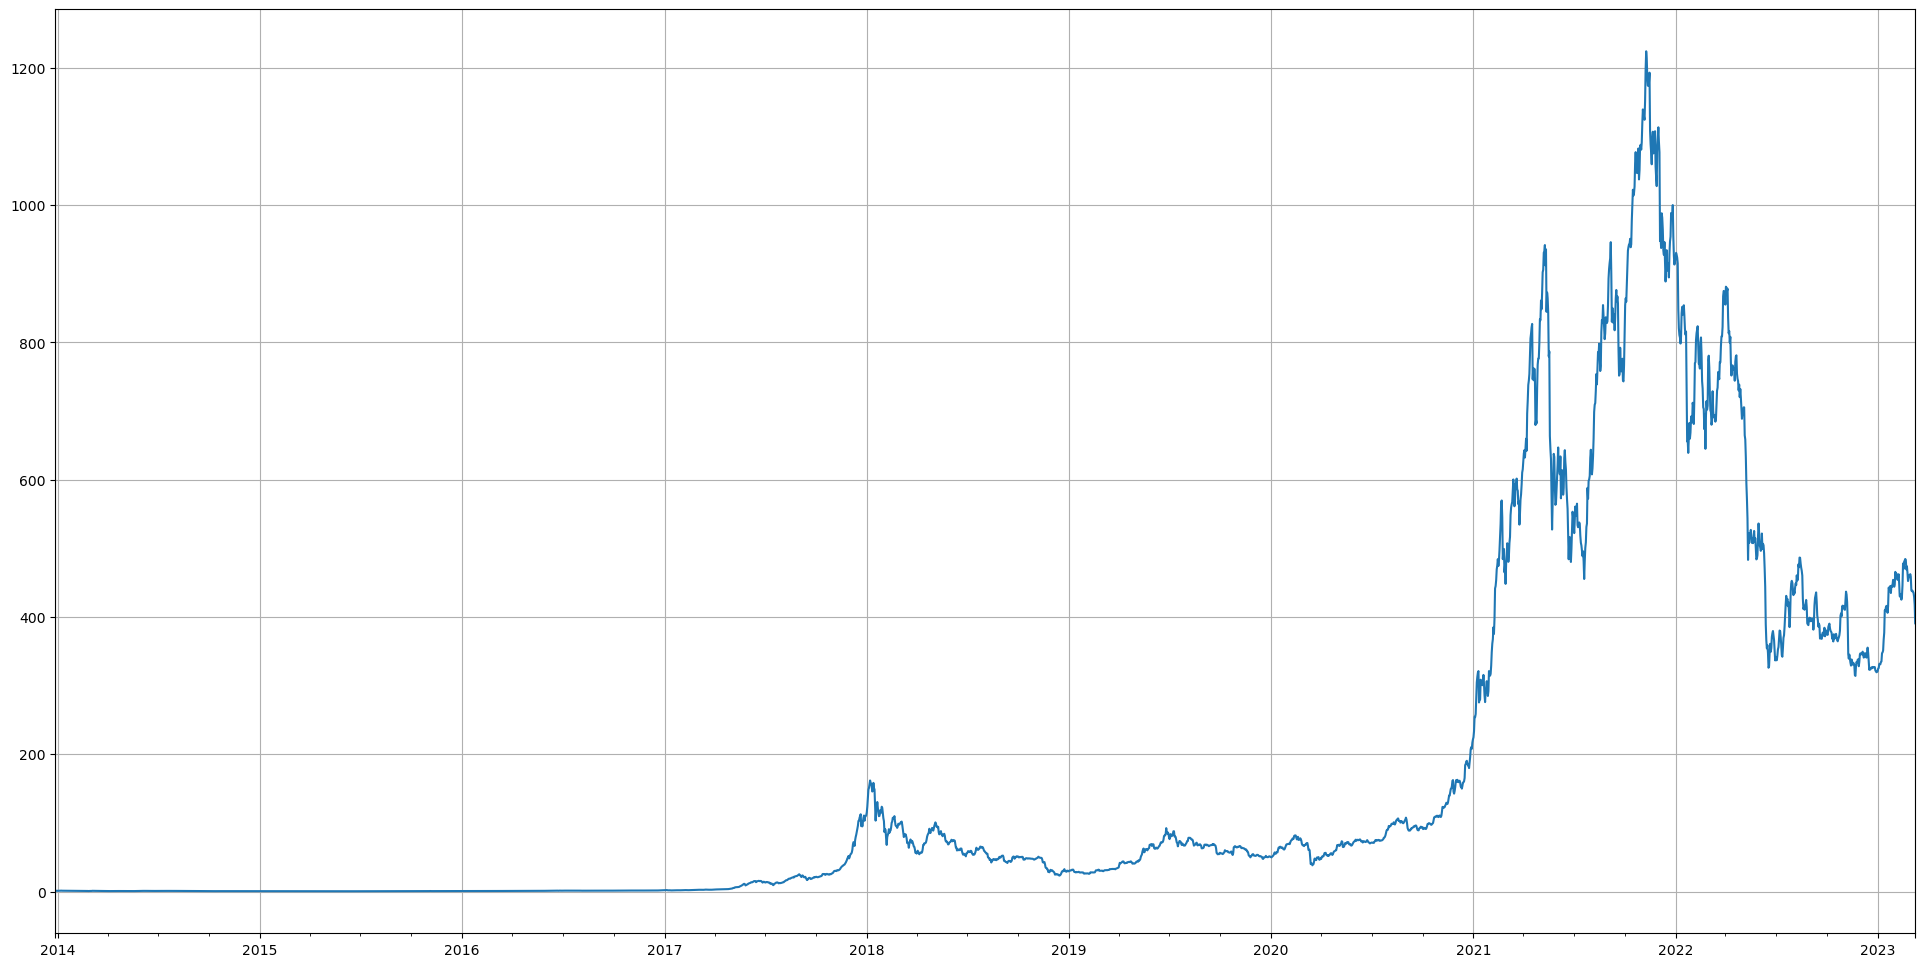

In [6]:
# 마켓 리턴      "2013-12-27"
mkt_rtn = ((rtn.loc["2013-12-27":] * new_weight).sum(1))

(mkt_rtn + 1).cumprod().plot(figsize=(24,12))
plt.grid();

Cross-Sectional : Weekly Rebalancing

In [7]:
mktcap = pd.read_pickle("ryu_new_mktcap9.pickle")
price  = pd.read_pickle("ryu_new_price9.pickle")
vol = pd.read_pickle("ryu_new_volume9.pickle")

daily_rtn = price.pct_change(fill_method=None) * np.sign(price)
vol_mask = (vol.rolling(window=20, min_periods=5).mean() > 1_000_000)\
               .replace({False: np.nan, True: 1})

# vol>100000 으로 잘랐다
daily_mktcap = vol_mask * mktcap
daily_rtn_pp = vol_mask * daily_rtn

In [8]:
# daily_mktcap의 각 날에 포함된 코인이 0보다 큰 날을 찾아보자
sum_num = (~daily_mktcap.isna()).sum(1)
sum_num.loc[sum_num>0]

2013-12-27      1
2013-12-28      2
2013-12-29      2
2013-12-30      2
2013-12-31      2
             ... 
2023-03-06    464
2023-03-07    463
2023-03-08    456
2023-03-09    454
2023-03-10    453
Length: 3361, dtype: int64

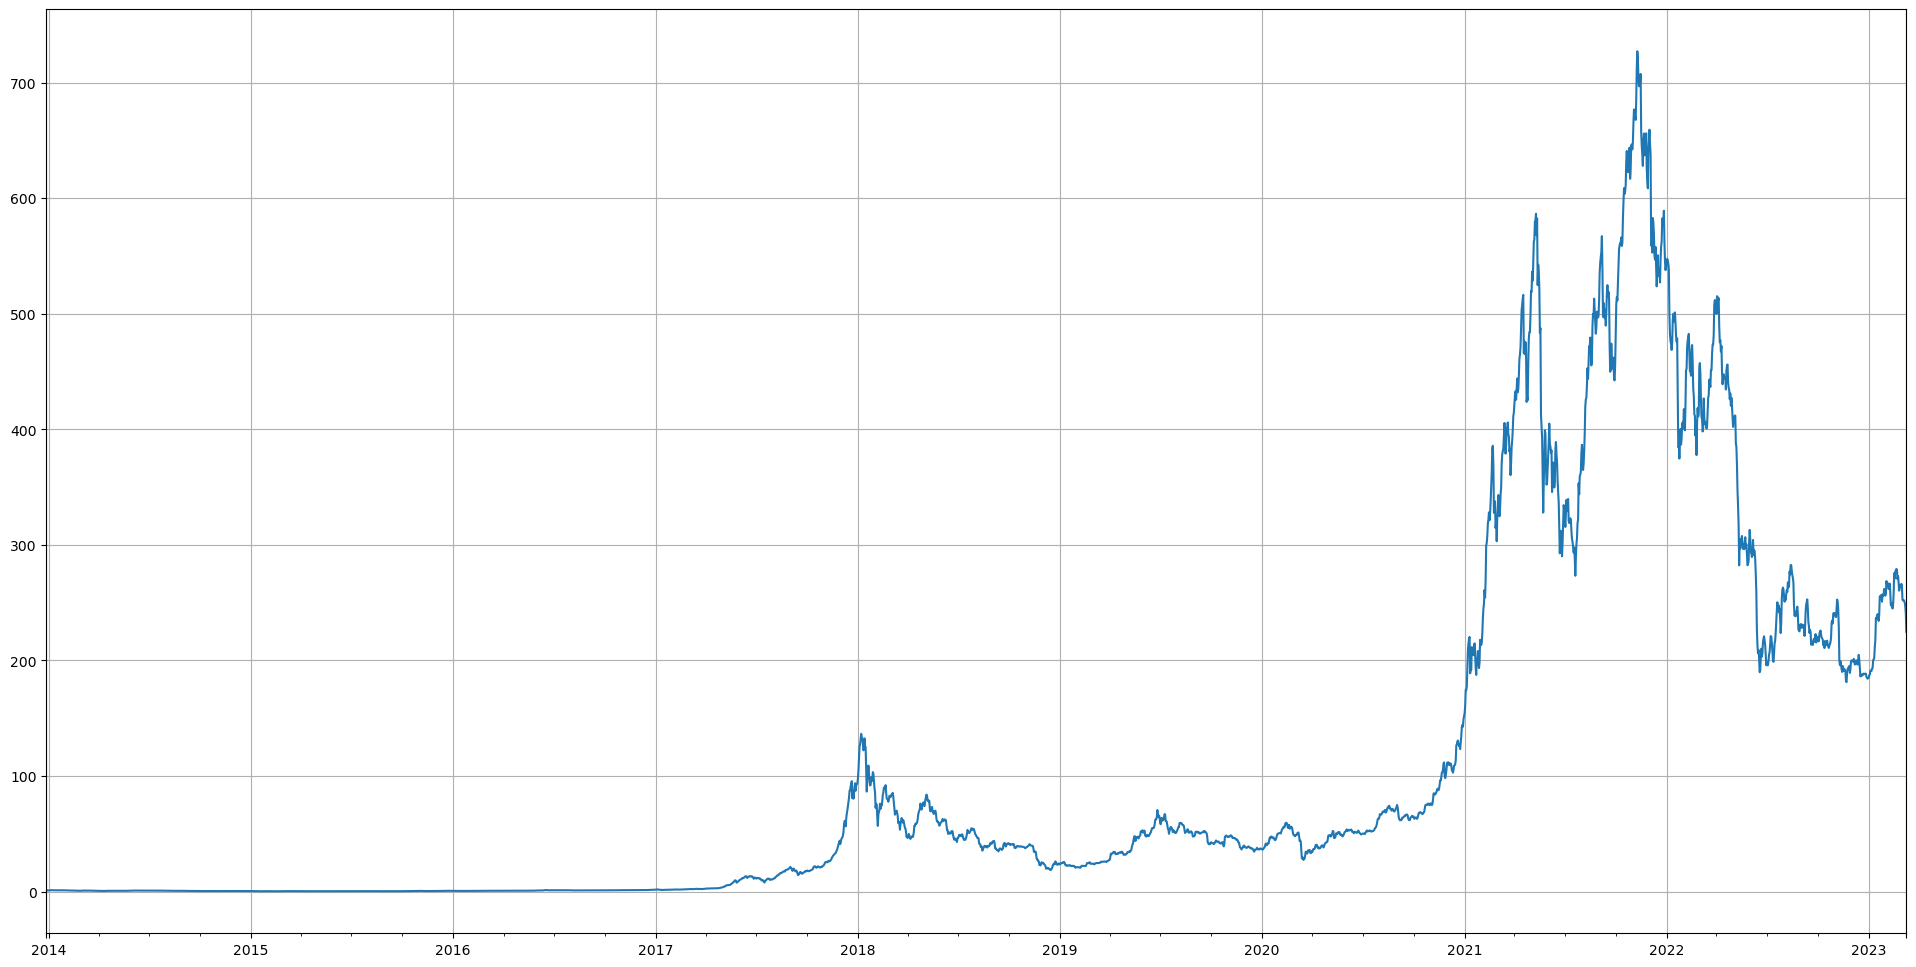

In [9]:
# 스크리닝을 통과한 마켓 인덱스
new_weight = daily_mktcap.apply(lambda x: x/np.nansum(x), axis=1)
new_mktrtn = (new_weight * daily_rtn).sum(1)

(new_mktrtn+1).loc["2013-12-27":].cumprod().plot(figsize=(24,12))
plt.grid();

In [10]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = daily_mktcap.count(1)
cnt.loc[cnt > 99]

2017-12-12    100
2017-12-13    103
2017-12-14    104
2017-12-15    108
2017-12-16    113
             ... 
2023-03-06    464
2023-03-07    463
2023-03-08    456
2023-03-09    454
2023-03-10    453
Length: 1912, dtype: int64

In [11]:
# return도 같은 기간으로 잘라야함
start_date = "2017-12-12"
daily_rtn_sample = daily_rtn.loc[start_date:]
daily_mktcap_sample = daily_mktcap.loc[start_date:]

# 나중에 plot할때도 필요해서 market rtn도 구해둬야한다
mktrtn_sample = mkt_rtn.loc[start_date:]

In [12]:
# 상관관계 확인
pd.concat([mktrtn_sample, mktrtn_sample.shift(1)], axis=1).corr()

,0,1
0,1.000000,0.199582
1,0.199582,1.000000


In [13]:
# 각 그룹의 filter를 구하고, 그것을 mkt와 곱한이후, 각 그룹의 weight를 구해야하는데, mktcap과 곱하는 과정에서 없어지는 코인이 너무 많은것
## 해결 -> mktcap으로 마스킹

## 우선 mktcap에 음수값이 있는 지 확인
print((daily_mktcap_sample <= 0).sum().sum())

daily_rtn_sample_pp = daily_rtn_sample * np.sign(daily_mktcap_sample)

0


In [14]:
# rank를 계산해줍니다
rank = daily_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

2017-12-12            [0, 20, 40, 60, 80]
2017-12-13       [0, 20, 40, 60, 80, 100]
2017-12-14       [0, 20, 40, 60, 80, 100]
2017-12-15       [0, 21, 42, 63, 84, 105]
2017-12-16       [0, 22, 44, 66, 88, 110]
                         ...             
2023-03-06    [0, 92, 184, 276, 368, 460]
2023-03-07    [0, 92, 184, 276, 368, 460]
2023-03-08    [0, 91, 182, 273, 364, 455]
2023-03-09    [0, 90, 180, 270, 360, 450]
2023-03-10    [0, 90, 180, 270, 360, 450]
Length: 1915, dtype: object

In [15]:
g1_mask = rank.apply(lambda x: x < t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 <= x)&(x < t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 <= x)&(x < t3), axis=0) \
              .replace({True:1, False:np.nan})    
g4_mask = rank.apply(lambda x: (t3 <= x)&(x < t4), axis=0) \
              .replace({True:1, False:np.nan})     
g5_mask = rank.apply(lambda x: x >= t4, axis=0) \
              .replace({True:1, False:np.nan})           

KeyboardInterrupt: 

In [ ]:
# 각 그룹에 무슨 코인 들었는 지 찾기
g5_coin = pd.Series()

for time, df in g5_mask.iterrows():
    coin = list(df.loc[~df.isna()].index)
    g5_coin[time] = coin
    
print(g5_coin)

2017-12-12    [DASH, DCT, ETH, FCT, FTC, IOP, LTC, MTL, MUE,...
2017-12-13    [BTS, DCR, DOGE, ETH, ETP, KNCL, LBC, LTC, MAN...
2017-12-14    [ADA, BCH, BTS, CDT, DATA, DGB, FIRO, GAME, KN...
2017-12-15    [ADA, AE, AVT, BCN, BTC, BTS, DATA, DGB, DLT, ...
2017-12-16    [ADA, ARN, BTS, CDT, CND, DATA, DLT, DOGE, ENJ...
                                    ...                        
2023-03-06    [1INCH, ADP, ALCX, ALPACA, ALPHA, AMO, ANC3, A...
2023-03-07    [ACM, ALCX, ALPACA, ANC3, ARDR, ARPA, ASR, ATM...
2023-03-08    [ACM, ADX, AION, ALPACA, ASR, BAL, BDX, BEAM, ...
2023-03-09    [ADX, AION, AMO, AMP, ANC3, APM, APT, ASR, BDX...
2023-03-10    [ABBC, ADA, AION, AMO, ANC3, APT, AR, ASR, ATO...
Length: 1915, dtype: object


In [ ]:
# 각 그룹별 weight를 생성 : 리턴을 보고, Mask를 만든 다음에,  mktcap에 곱해서 weight를 만든다(내일 이 weight를 가져갈거임)
weight_g1 = (g1_mask * daily_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * daily_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * daily_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * daily_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * daily_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [ ]:
# 그룹별 코인 개수 출력 
concat = pd.concat([weight_g1.count(1), weight_g2.count(1),
                    weight_g3.count(1), weight_g4.count(1),
                    weight_g5.count(1)], axis=1)#.plot();

coin = pd.concat([concat, concat.sum(1)], axis=1)
coin.columns = [0,1,2,3,4,"Sum"]

coin

,0,1,2,3,4,Sum
2017-12-12,19,20,20,20,21,100
2017-12-13,19,20,20,20,24,103
2017-12-14,19,20,20,20,25,104
2017-12-15,20,21,21,21,25,108
2017-12-16,21,22,22,22,25,112
...,...,...,...,...,...,...
2023-03-06,91,92,92,92,97,464
2023-03-07,91,92,92,92,96,463
2023-03-08,90,91,91,91,93,456
2023-03-09,89,90,90,90,95,454


In [ ]:
#concat.plot(figsize=(24,12));

In [ ]:
# filter를 마켓켑과 리턴에 곱해줘서 각 그룹별 리턴 계산
rtn_g1 = (daily_rtn_sample * weight_g1.shift(1))
rtn_g2 = (daily_rtn_sample * weight_g2.shift(1))
rtn_g3 = (daily_rtn_sample * weight_g3.shift(1))
rtn_g4 = (daily_rtn_sample * weight_g4.shift(1))
rtn_g5 = (daily_rtn_sample * weight_g5.shift(1))

In [ ]:
concat2 = pd.concat([rtn_g1.count(1), rtn_g2.count(1),
                    rtn_g3.count(1), rtn_g4.count(1),
                    rtn_g5.count(1)], axis=1)#.plot();

coin2 = pd.concat([concat2, concat2.sum(1)], axis=1)
coin2.columns = [0,1,2,3,4,"Sum"]

coin2

,0,1,2,3,4,Sum
2017-12-12,0,0,0,0,0,0
2017-12-13,19,20,20,20,21,100
2017-12-14,19,20,20,20,24,103
2017-12-15,19,20,20,20,25,104
2017-12-16,20,21,21,21,25,108
...,...,...,...,...,...,...
2023-03-06,92,93,93,93,94,465
2023-03-07,91,92,92,92,97,464
2023-03-08,91,92,92,92,96,463
2023-03-09,90,91,91,91,93,456


In [ ]:
# 5번 그룹에서 각 요일별 최고 수익률을 기록한 코인들
rtn_g5.apply(lambda x: x.idxmax(), axis=1)

2017-12-12     NaN
2017-12-13     ETH
2017-12-14     XRP
2017-12-15     XRP
2017-12-16     BTC
              ... 
2023-03-06     UNI
2023-03-07     UNI
2023-03-08     XRP
2023-03-09     XRP
2023-03-10    KAVA
Length: 1915, dtype: object

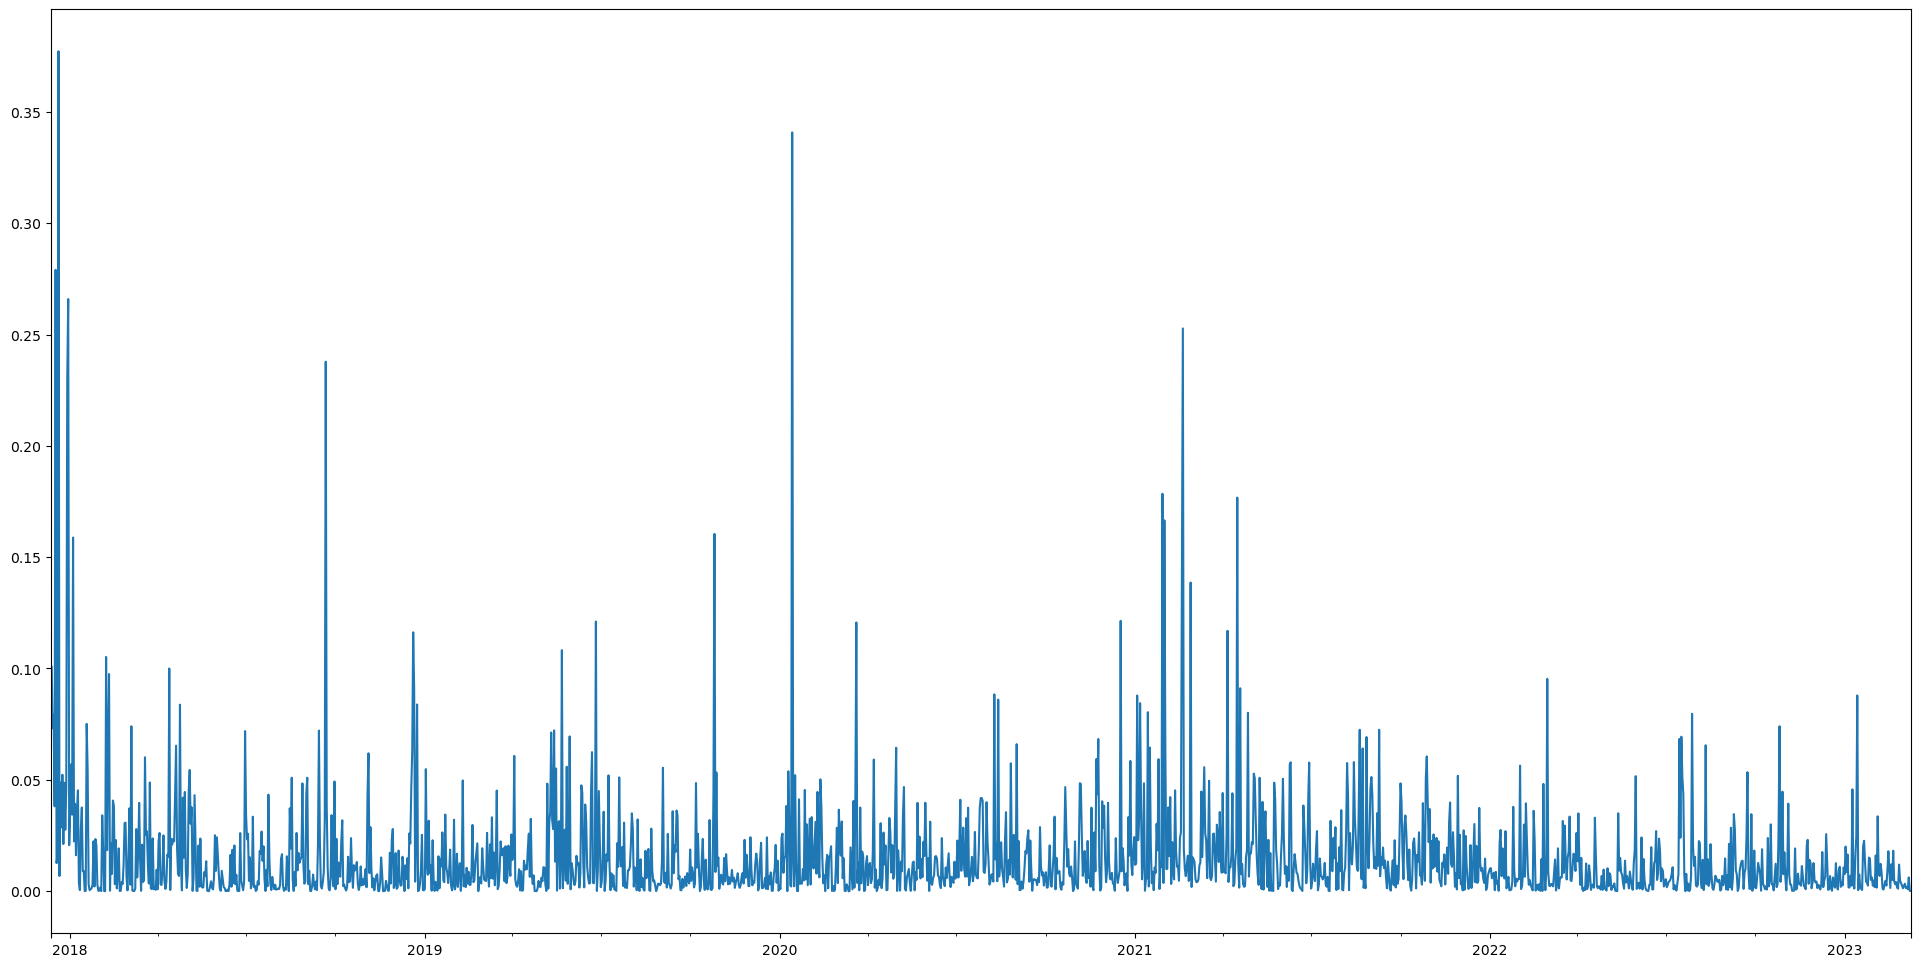

In [ ]:
rtn_g5.apply(lambda x: x.max(), axis=1).plot(figsize=(24,12));

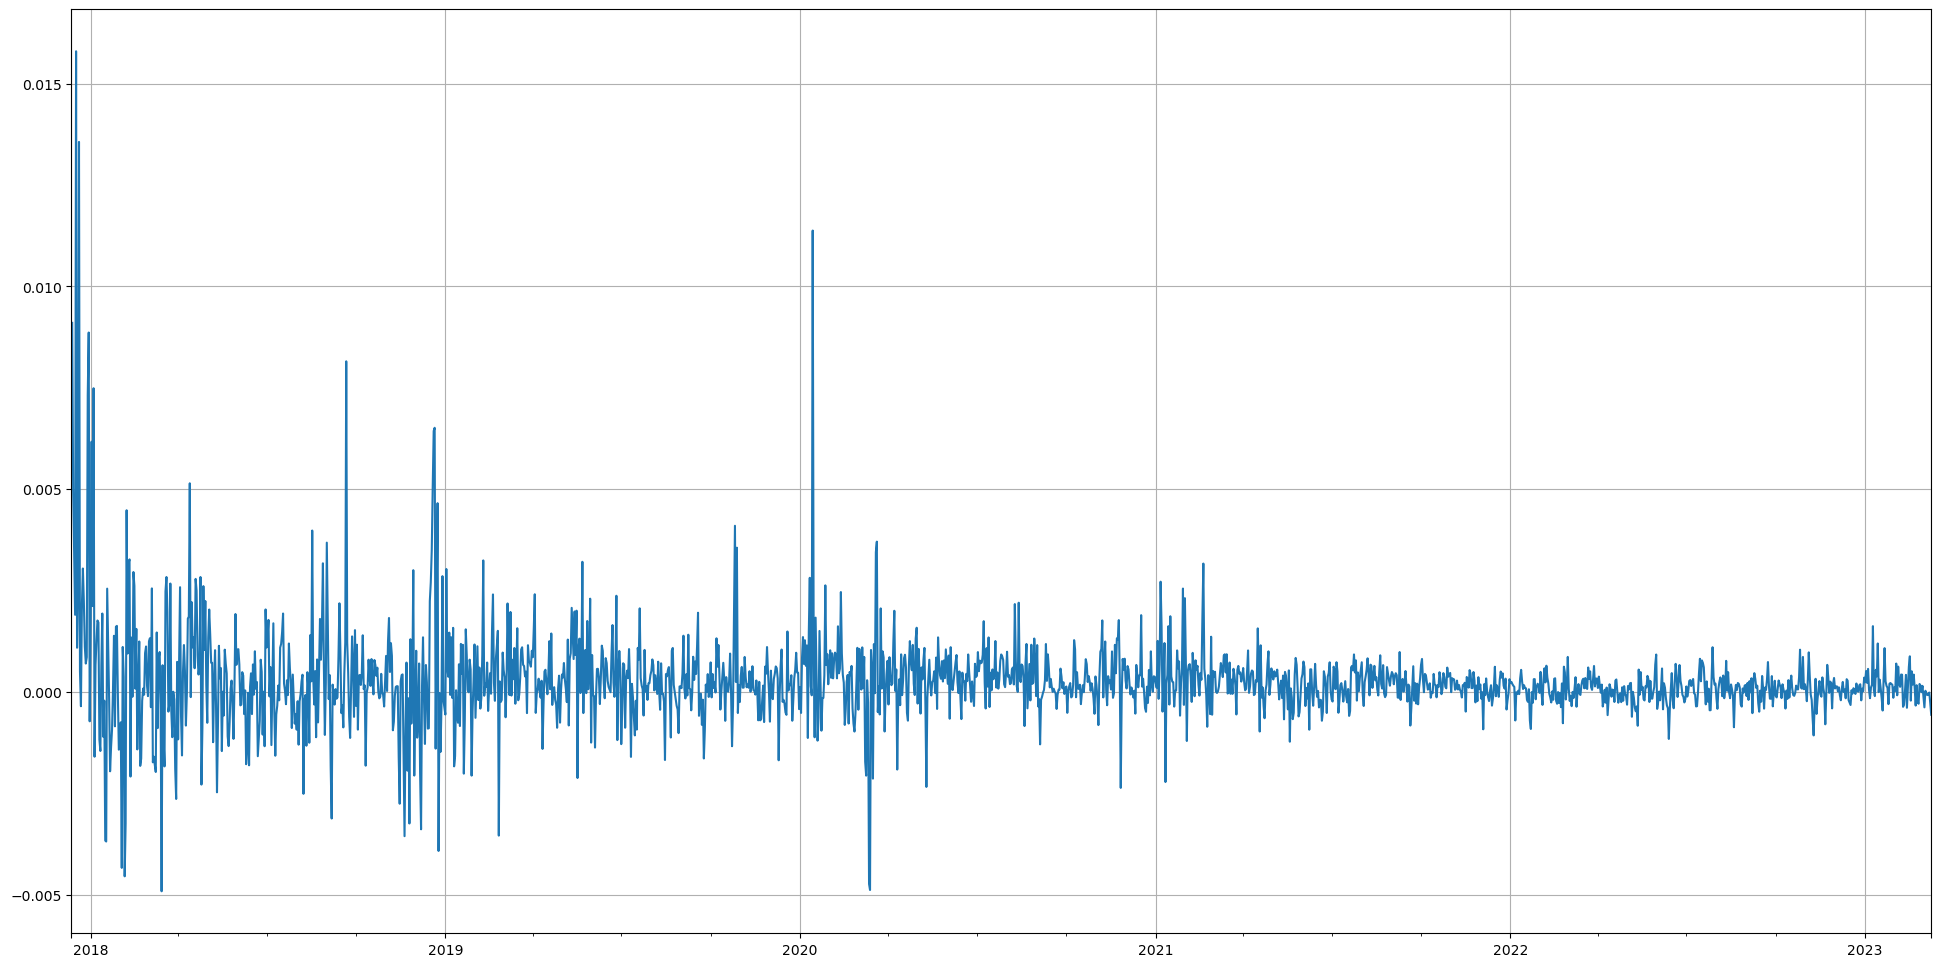

In [ ]:
rtn_g5.apply(lambda x: x.mean(), axis=1).plot(figsize=(24,12))
plt.grid();

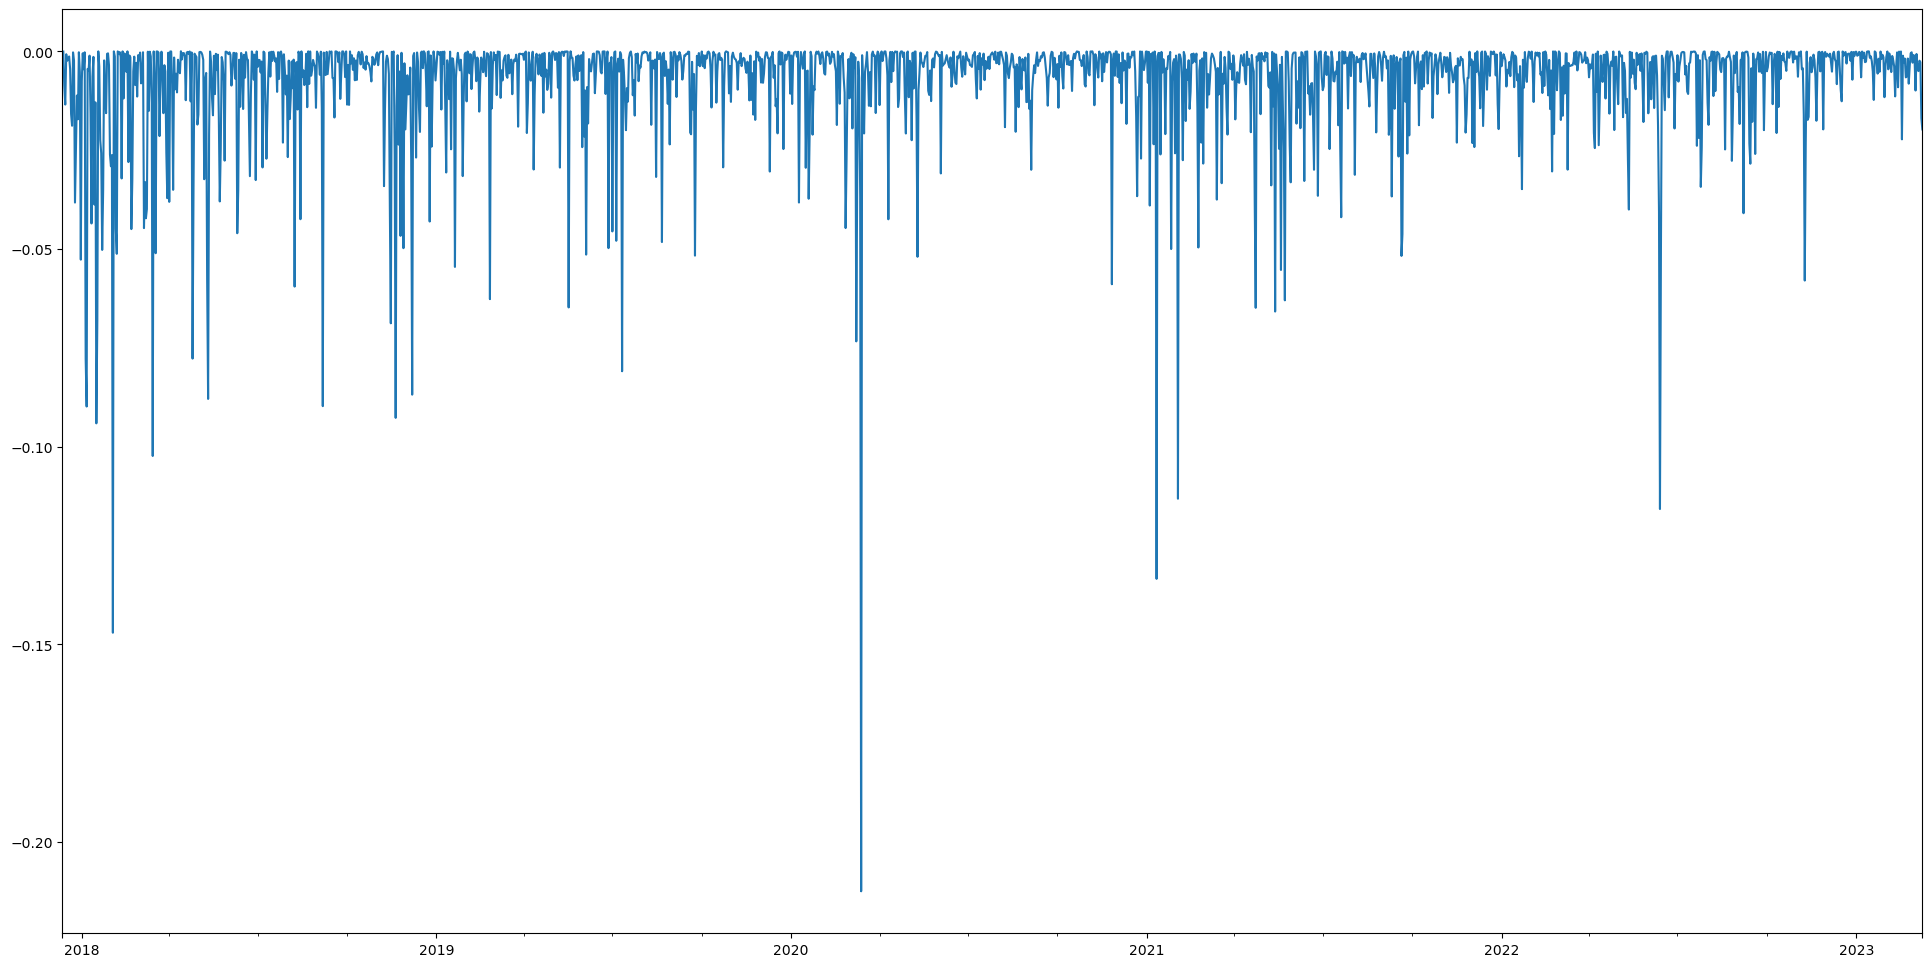

In [ ]:
rtn_g5.apply(lambda x: x.min(), axis=1).plot(figsize=(24,12));

In [ ]:
rtn_dict = {"Q1":rtn_g1.sum(1),
            "Q2":rtn_g2.sum(1),
            "Q3":rtn_g3.sum(1),
            "Q4":rtn_g4.sum(1),
            "Q5":rtn_g5.sum(1)}

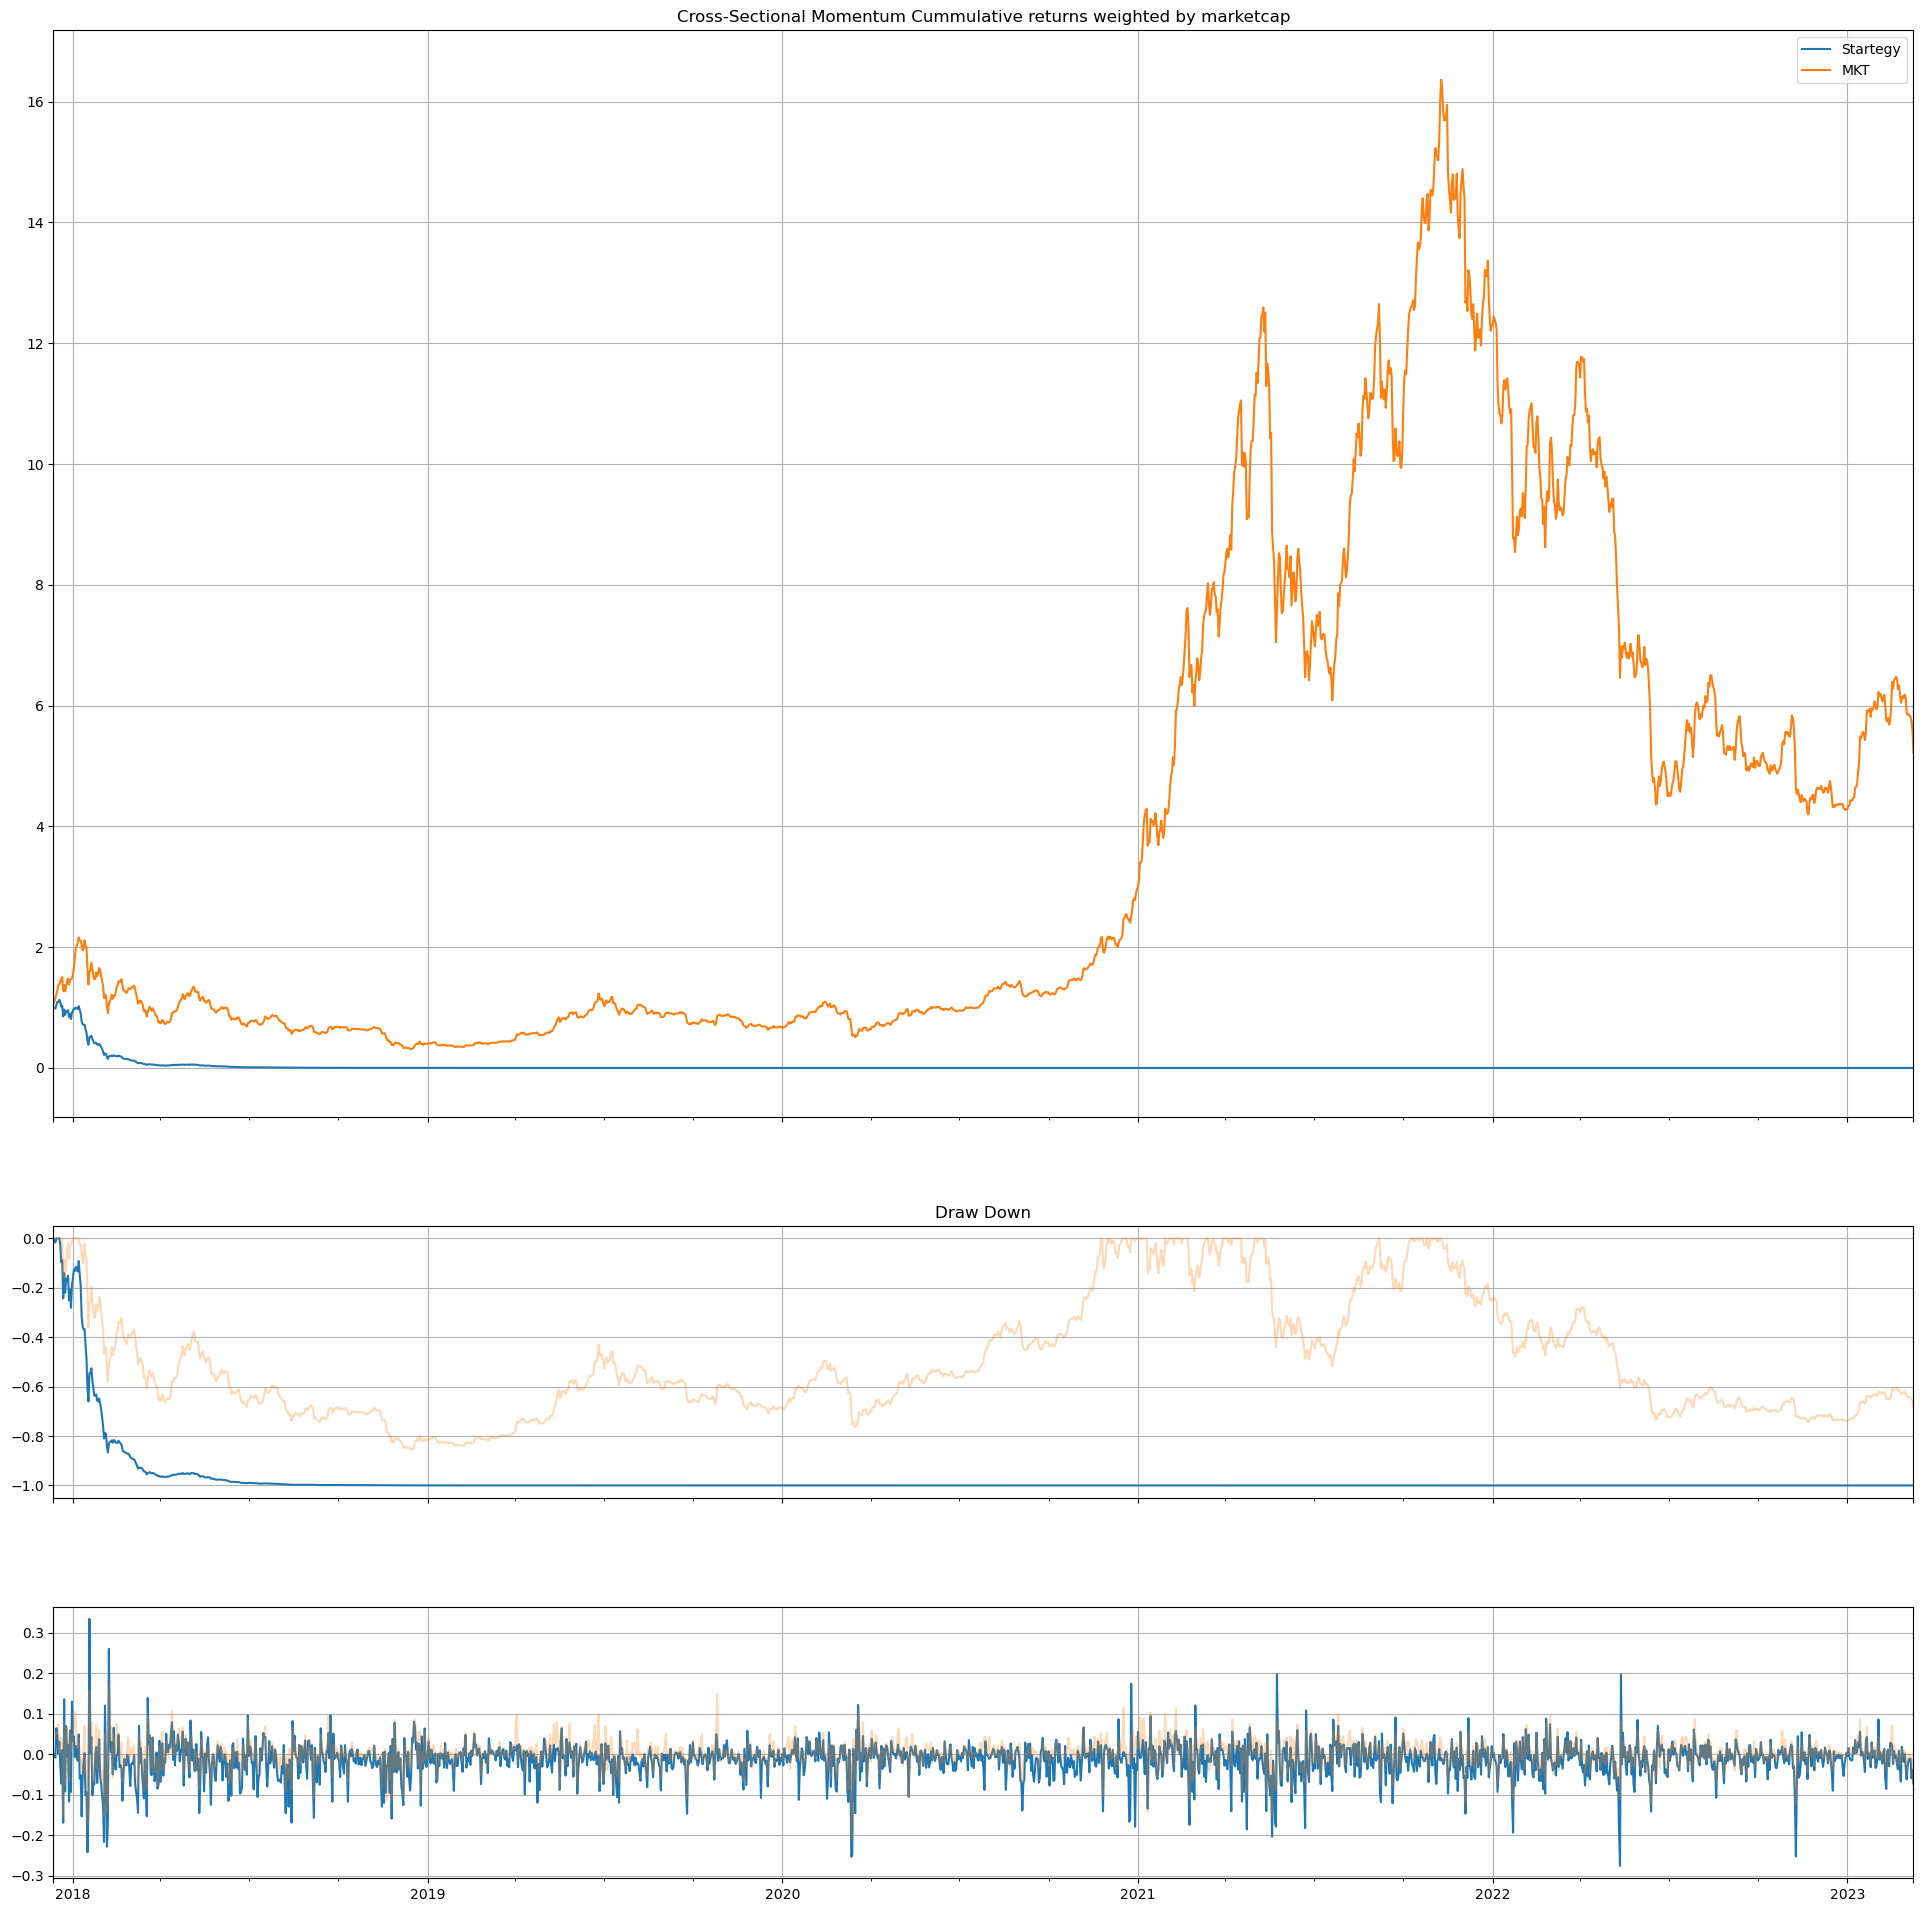

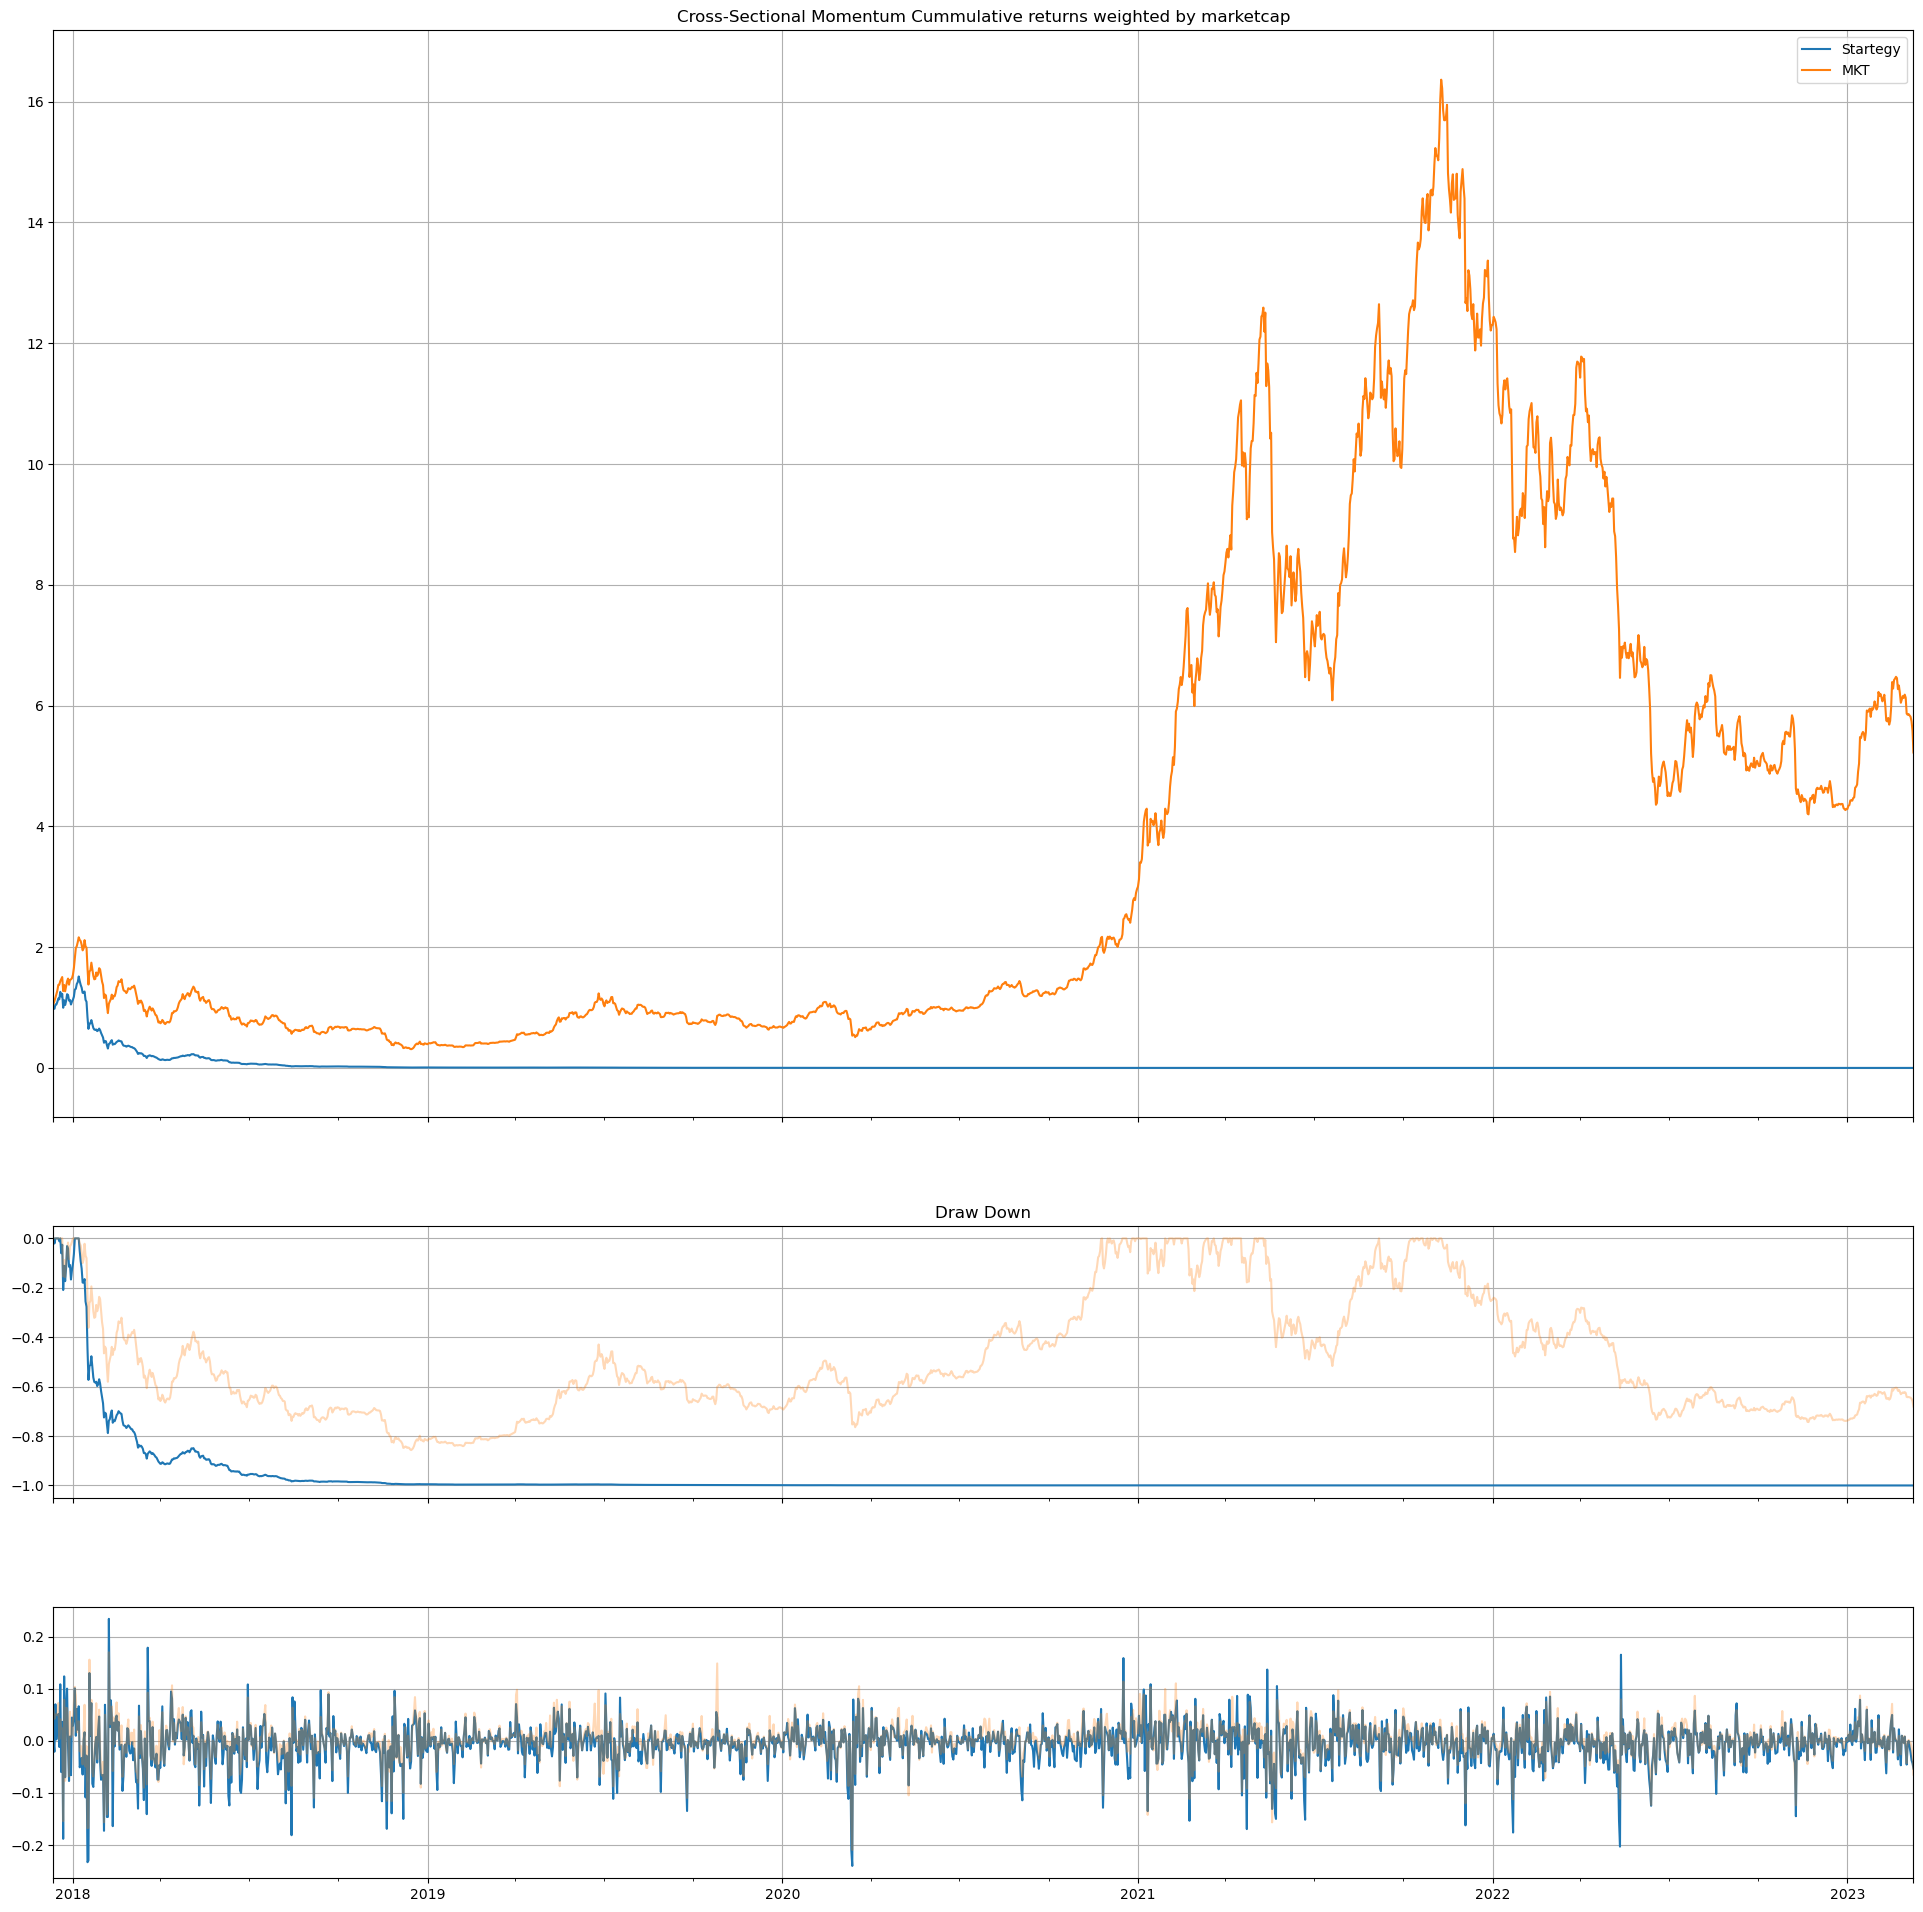

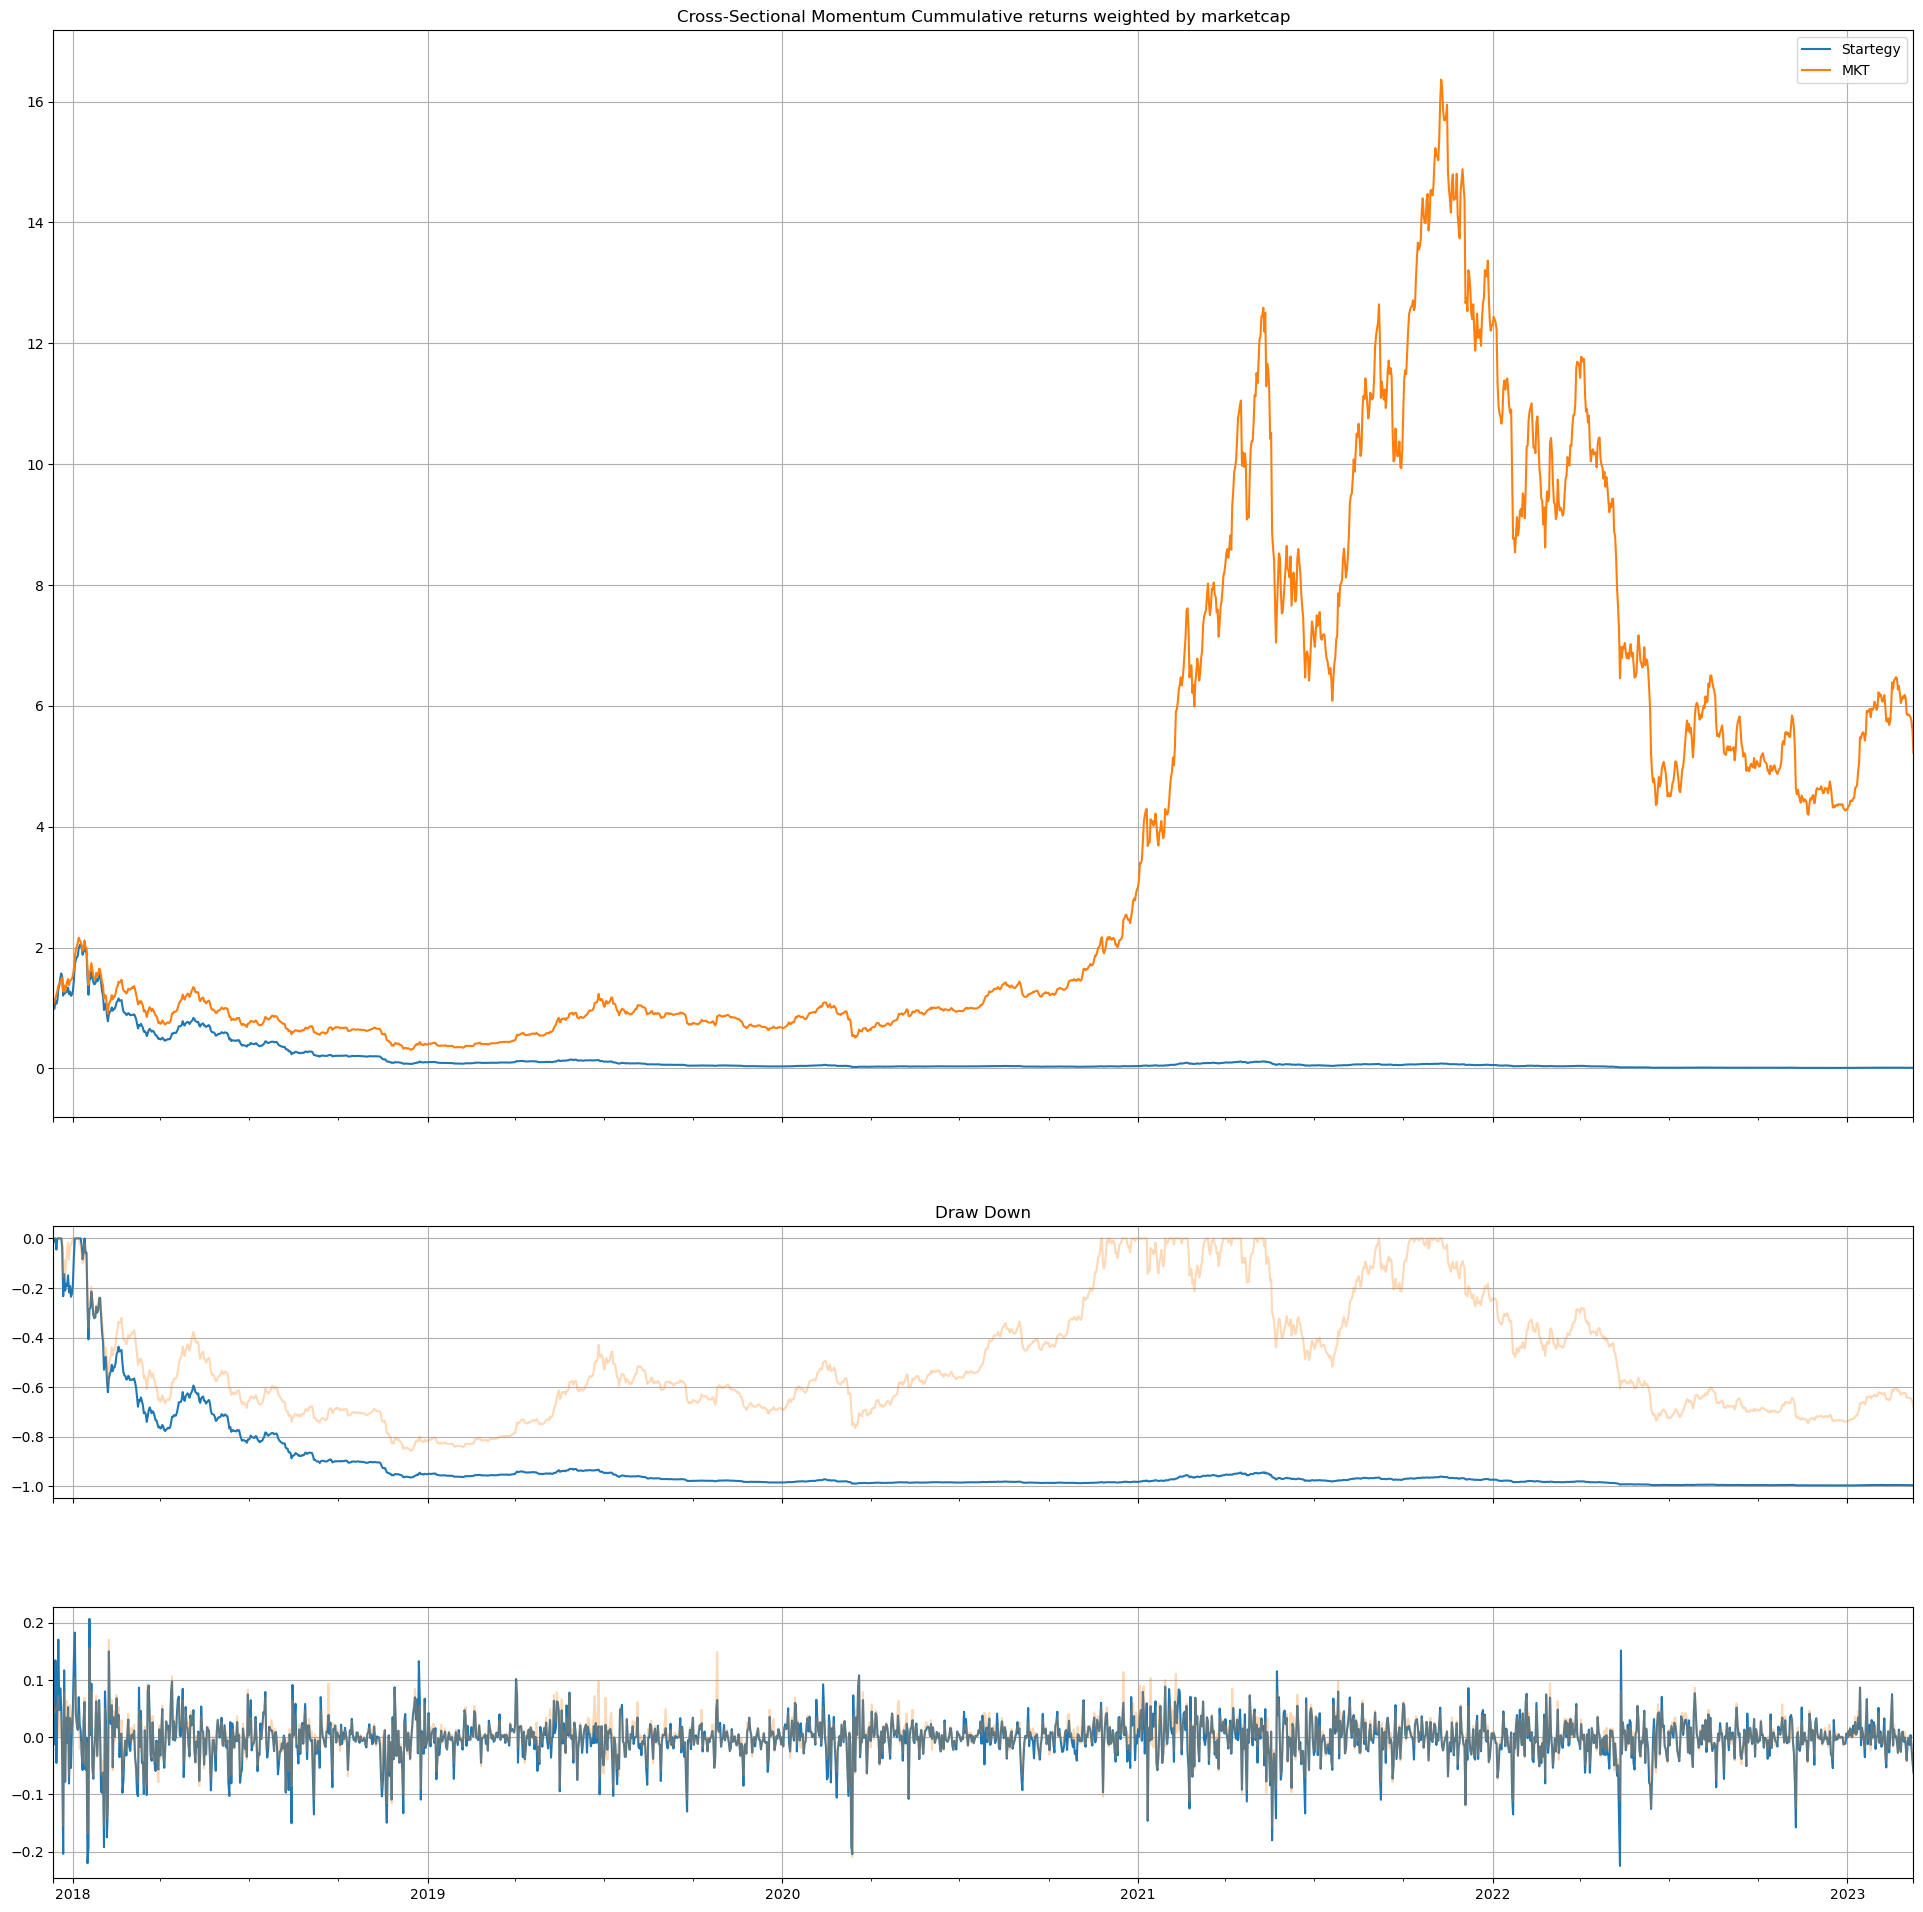

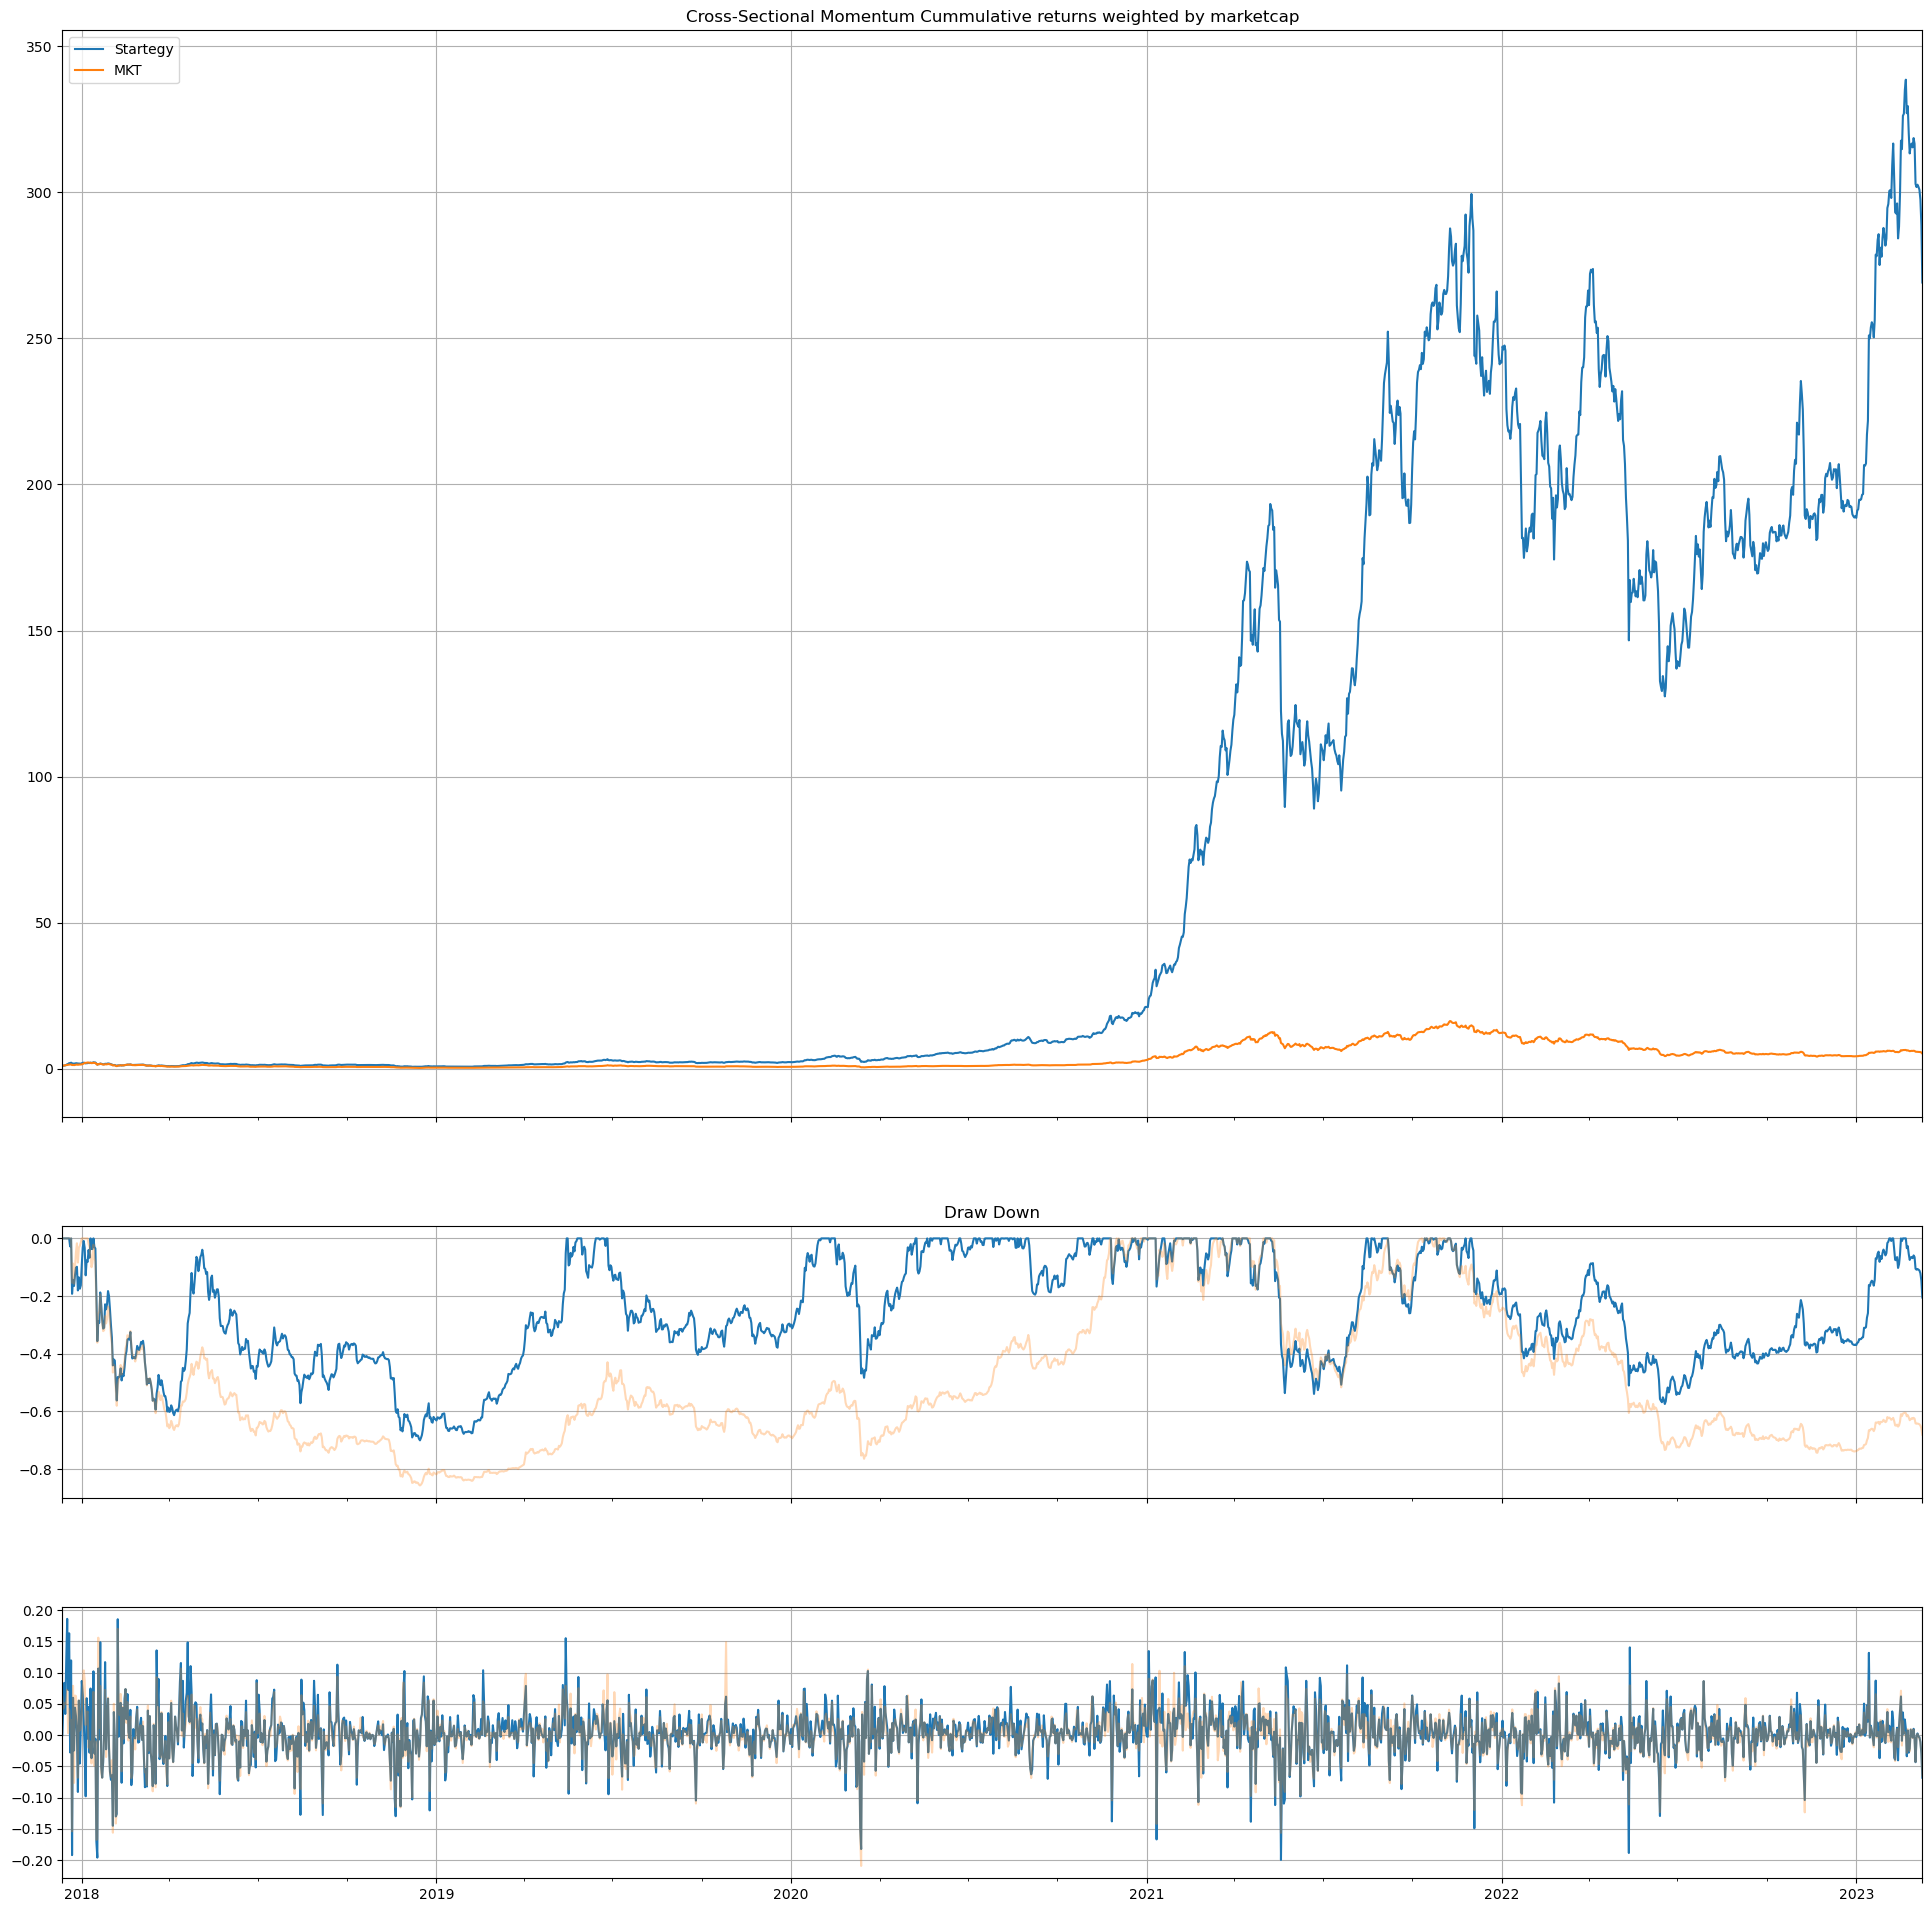

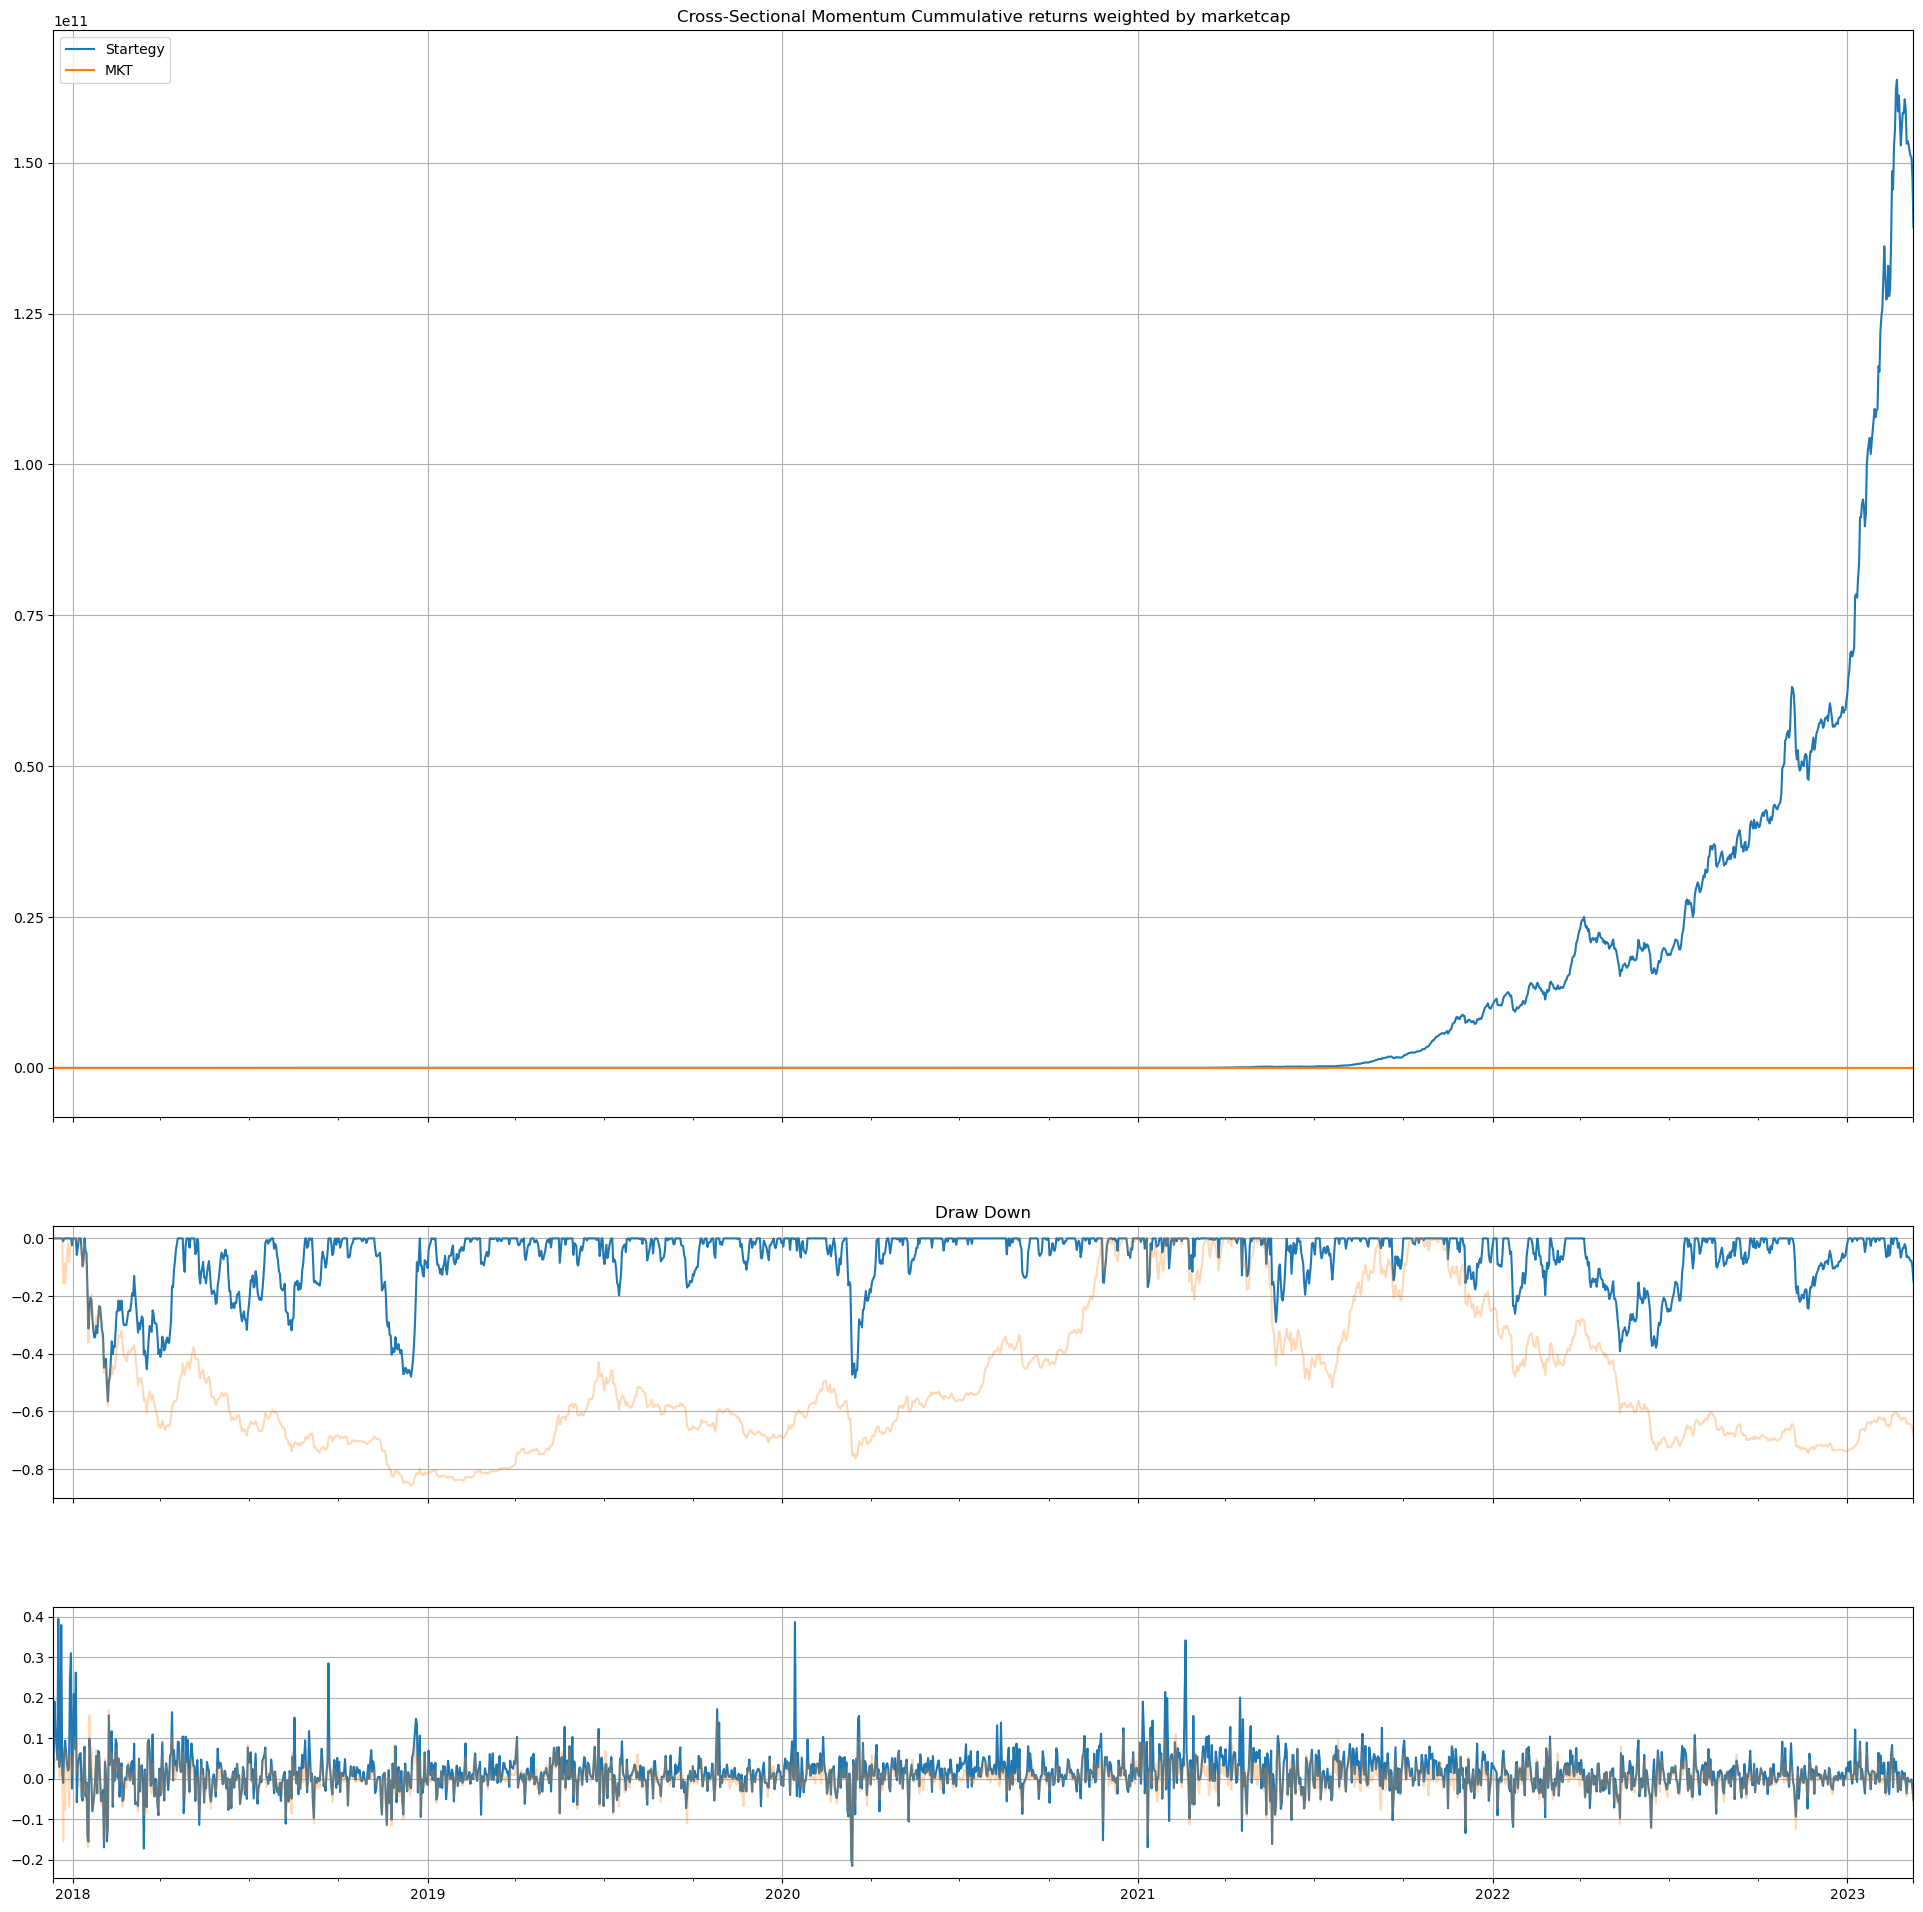

In [ ]:
draw_return_result(rtn_dict, with_mkt=True, mkt_rtn=mktrtn_sample)

In [ ]:
print_statistics(rtn_dict,
                 mkt_rtn=mktrtn_sample)

,0,1,2,3,4,MKT
CAGR,-99.638655,-91.487495,-58.580719,190.502739,13204.832818,35.479508
Mean,-0.014242,-0.005890,-0.001665,0.003664,0.014599,0.001452
STD,0.044779,0.040232,0.038144,0.038210,0.048070,0.034051
Shape,-6.076412,-2.797012,-0.833928,1.832012,5.802250,0.814654


In [ ]:
run_alpha_regression(rtn_dict,
                     mkt_rtn=mktrtn_sample)

Q1 Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.681     
Dependent Variable: y                AIC:                -8650.1789
Date:               2023-04-07 13:22 BIC:                -8639.0640
No. Observations:   1915             Log-Likelihood:     4327.1    
Df Model:           1                F-statistic:        4095.     
Df Residuals:       1913             Prob (F-statistic): 0.00      
R-squared:          0.682            Scale:              0.00063876
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      -0.0158     0.0006   -27.3646   0.0000   -0.0170   -0.0147
0           1.0857     0.0170    63.9940   0.0000    1.0524    1.1190
-------------------------------------------------------------------
Omnibus:             375.694       

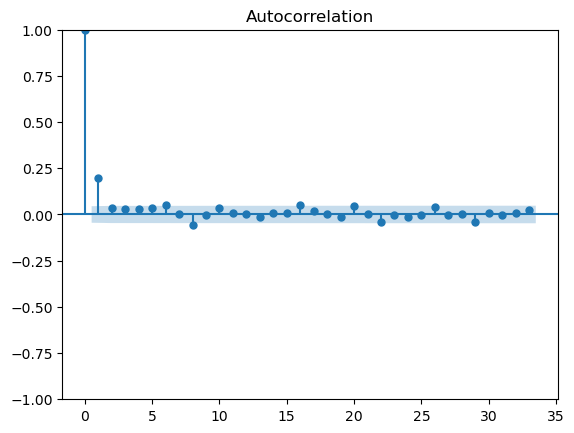

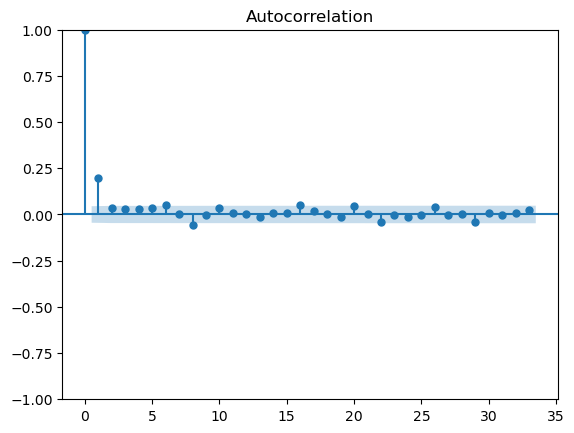

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(mktrtn_sample)